# Hockey Goals

> Fill in a module description here



## Imports

In [ ]:
# this next line shouldn't have to be here
%matplotlib inline 
%load_ext autoreload
%autoreload 1
%config InlineBackend.figure_format = 'retina'
%load_ext rich
import datetime
import hashlib
import json
import os
import re
import sys
import time
import warnings

import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.plotting import register_matplotlib_converters
from scipy.stats import norm
from ydata_profiling import ProfileReport

register_matplotlib_converters()
sns.set()
sns.set_context("notebook")
plt.rcParams["figure.figsize"] = 10, 6
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.precision = 4
warnings.simplefilter(action="ignore", category=FutureWarning)

dollar_formatter = FuncFormatter(lambda x, pos: f"${x:,.0f}")
thousands_formatter = FuncFormatter(lambda x, pos: f"{x:,.0f}")

## Constants

In [ ]:
DAYS_IN_YEAR = 365.25

## Data

### Raw

In [ ]:
game_goals_raw = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-03/game_goals.csv"
)
top_250_raw = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-03/top_250.csv"
)
season_goals_raw = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-03/season_goals.csv"
)

In [ ]:
game_goals_raw.head()

player  season  rank        date  game_num     age team   at  opp  \
0  Alex Ovechkin    2006     1  2005-10-05         1  20-018  WSH  NaN  CBJ   
1  Alex Ovechkin    2006     2  2005-10-07         2  20-020  WSH  NaN  ATL   
2  Alex Ovechkin    2006     3  2005-10-08         3  20-021  WSH    @  ATL   
3  Alex Ovechkin    2006     4  2005-10-10         4  20-023  WSH  NaN  NYR   
4  Alex Ovechkin    2006     5  2005-10-12         5  20-025  WSH    @  CAR   

  location outcome  goals  assists  points  plus_minus  penalty_min  \
0     Home       W      2        0       2           1            2   
1     Home       L      0        1       1          -2            0   
2     Away       L      0        1       1           0            4   
3     Home       W      1        0       1           1            2   
4     Away       L      1        0       1           0            0   

   goals_even  goals_powerplay  goals_short  goals_gamewinner  assists_even  \
0           1                1            0                 0           NaN   
1           0                0            0                 0           NaN   
2           0                0            0                 0           NaN   
3           0                1            0                 1           NaN   
4           1                0            0                 0           NaN   

   assists_powerplay  assists_short  shots  shot_percent  
0                NaN            NaN      5          40.0  
1                NaN            NaN      1           0.0  
2                NaN            NaN      3           0.0  
3                NaN            NaN      6          16.7  
4                NaN            NaN      6          16.7

In [ ]:
top_250_raw.head()

raw_rank         player    years  total_goals  url_number  \
0       1.0  Wayne Gretzky  1979-99          894           1   
1       2.0    Gordie Howe  1946-80          801           2   
2       3.0   Jaromir Jagr  1990-18          766           3   
3       4.0     Brett Hull  1986-06          741           4   
4       5.0  Marcel Dionne  1971-89          731           5   

                    raw_link  \
0  /players/g/gretzwa01.html   
1   /players/h/howego01.html   
2   /players/j/jagrja01.html   
3   /players/h/hullbr01.html   
4  /players/d/dionnma01.html   

                                                link   active  yr_start  
0  https://www.hockey-reference.com/players/g/gre...  Retired      1979  
1  https://www.hockey-reference.com/players/h/how...  Retired      1946  
2  https://www.hockey-reference.com/players/j/jag...  Retired      1990  
3  https://www.hockey-reference.com/players/h/hul...  Retired      1986  
4  https://www.hockey-reference.com/players/d/dio...  Retired      1971

In [ ]:
season_goals_raw.head()

rank position  hand         player    years  total_goals   status  \
0     1        C  Left  Wayne Gretzky  1979-99          894  Retired   
1     1        C  Left  Wayne Gretzky  1979-99          894  Retired   
2     1        C  Left  Wayne Gretzky  1979-99          894  Retired   
3     1        C  Left  Wayne Gretzky  1979-99          894  Retired   
4     1        C  Left  Wayne Gretzky  1979-99          894  Retired   

   yr_start   season  age team league  season_games  goals  assists  points  \
0      1979  1978-79   18  TOT    WHA            80     46       64     110   
1      1979  1978-79   18  INR    WHA             8      3        3       6   
2      1979  1978-79   18  EDO    WHA            72     43       61     104   
3      1979  1979-80   19  EDM    NHL            79     51       86     137   
4      1979  1980-81   20  EDM    NHL            80     55      109     164   

   plus_minus  penalty_min  goals_even  goals_power_play  goals_short_handed  \
0        20.0           19         NaN               NaN                 NaN   
1        -3.0            0         3.0               0.0                 0.0   
2        23.0           19        34.0               9.0                 0.0   
3        14.0           21        37.0              13.0                 1.0   
4        41.0           28        36.0              15.0                 4.0   

   goals_game_winner                                           headshot  
0                NaN  https://d9kjk42l7bfqz.cloudfront.net/req/20191...  
1                NaN  https://d9kjk42l7bfqz.cloudfront.net/req/20191...  
2                NaN  https://d9kjk42l7bfqz.cloudfront.net/req/20191...  
3                6.0  https://d9kjk42l7bfqz.cloudfront.net/req/20191...  
4                3.0  https://d9kjk42l7bfqz.cloudfront.net/req/20191...

## Functions

In [ ]:
def raw_game_to_clean(raw):
    return raw.assign(
        years_old=(
            (
                ((raw["age"].str.split("-").str[0].astype(float)) * DAYS_IN_YEAR)
                + raw["age"].str.split("-").str[1].astype(float)
            )
            / DAYS_IN_YEAR
        )
    )


def raw_top_to_clean(raw):
    # prob ffill raw_rank
    return raw


def raw_season_to_clean(raw):
    return raw


def list_of_top_n_playernames(top_n=8):
    return top_250.iloc[:top_n]["player"].to_list()

In [ ]:
game_goals = raw_game_to_clean(game_goals_raw)
top_250 = raw_top_to_clean(top_250_raw)
season_goals = raw_season_to_clean(season_goals_raw)

## EDA

In [ ]:
game_profile = ProfileReport(game_goals, config_file="config_minimal.yaml")
top_profile = ProfileReport(top_250, config_file="config_minimal.yaml")
season_profile = ProfileReport(season_goals, config_file="config_minimal.yaml")

In [ ]:
game_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.HTML object>

<class 'ydata_profiling.profile_report.ProfileReport'>.__repr__ returned empty string

In [ ]:
top_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.HTML object>

<class 'ydata_profiling.profile_report.ProfileReport'>.__repr__ returned empty string

In [ ]:
season_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.HTML object>

<class 'ydata_profiling.profile_report.ProfileReport'>.__repr__ returned empty string

## Plots

### Warning -- dataset might have problems -- the sum of the goals in the seasons don't match the top dataset?

In [ ]:
for player_name in list_of_top_n_playernames(top_n=8):
    sum_goals = season_goals[season_goals["player"] == player_name]["goals"].sum()
    top_goals = top_250[top_250["player"] == player_name]["total_goals"].values[0]
    print(f"{top_goals - sum_goals}, {player_name}")

-115, Wayne Gretzky
-174, Gordie Howe
-64, Jaromir Jagr
-32, Brett Hull
-28, Marcel Dionne
-35, Phil Esposito
-139, Mike Gartner
0, Alex Ovechkin


### What do the cumulative goals scored look like as a function of age for the top scorers?

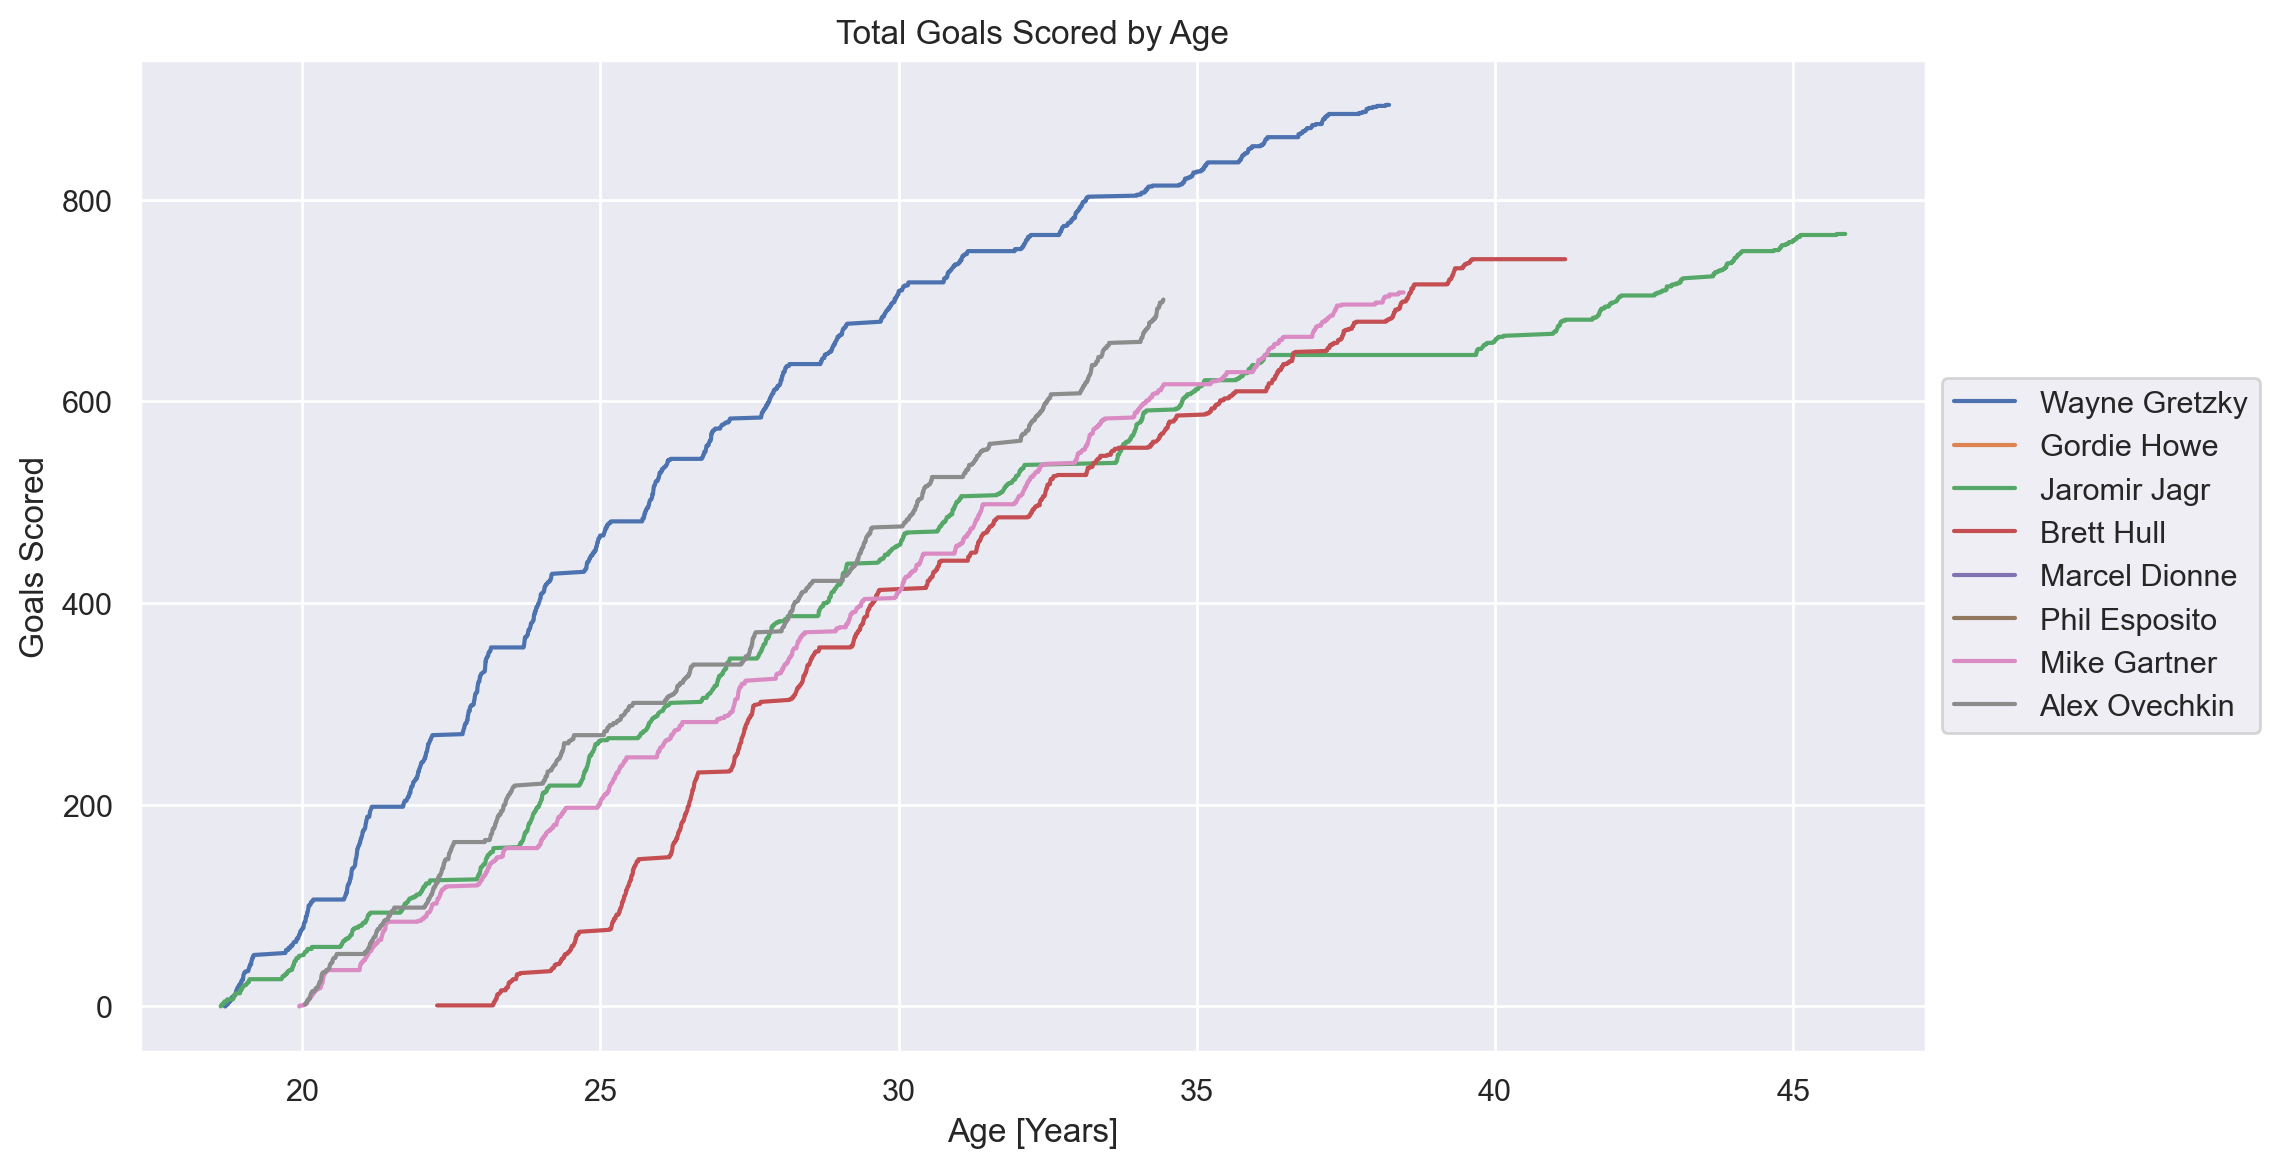

In [ ]:
# player_name = "Alex Ovechkin"
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor("w")

for player_name in list_of_top_n_playernames(top_n=8):
    plotdf = game_goals[game_goals["player"] == player_name]
    ax.plot(plotdf["years_old"], plotdf["goals"].cumsum(), label=player_name)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("Total Goals Scored by Age")
ax.set_xlabel("Age [Years]")
ax.set_ylabel("Goals Scored")
fig.tight_layout()

## Clean up Notebook 

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()